# Redes Bayesianas Discretas: Introducción a Bnlearn
#### Master in Data Science - Machine Learning II
#### Santander Meteorology Group. Profesor: Mikel N. Legasa (legasam@unican.es)
#### 6 Mar 2018
La presente práctica esta concebida como una primera aproximación a los fundamentos de las redes bayesianas, encargándonos simplemente de la modelización de variables discretas mediante una red bayesiana siguiendo el esquema:

1. Introducción.
2. Construcción de la Red Bayesiana, tanto su estructura (Construcción del DAG) y sus parámetros (Construcción de las tablas de probabilidad condicionada).
3. Obtención de información cualitativa a partir del grafo (Consultas al grafo).
 Con la idea de familiarizarnos con la librería `bnlearn` y sus estructuras y funciones

## 1 Introducción
#### 1.1 Dataset de ejemplo: Survey
El objetivo de una Red Bayesiana es capturar la distribución de probabilidad conjunta de un conjunto de variables $\mathcal{X} = X_1, X_2, ...$.

A modo de ejemplo, utilizaremos los datos de una encuesta sobre utilización de medios de transporte, donde cada variable tiene un número finito de posibles estados. A partir de los datos de campo recogidos por la encuesta, se investigará la selección de medios de transporte por distintos perfiles de usuarios, y particularmente la preferencia de tren o coche. 

Este tipo de análisis se utiliza con frecuencia en la planificación de infraestructuras. Para cada individuo encuestado, se han recopilado datos referentes a 6 variables discretas. Las abreviaturas de dichas variables se muestran entre paréntesis (original del dataset en inglés), y se utilizarán a lo largo de la práctica para referirse a los nodos de la red creada.

- Edad (A): Edad del encuestado: joven (`young`, < 30 años), adulto (`adult`, 30 < edad <= 60) y anciano (`old`, edad > 60).
- Sexo (S): Sexo del encuestado: masculino (`M`) y femenino (`F`).
- Educación (E): Nivel más alto de educación alcanzado: Hasta educación secundaria (`high`) o título universitario (`uni`).
- Ocupación (O): Trabajador por cuenta ajena (`emp`) o autónomo (`self`).
- Residencia (R): Tamaño de la población de residencia del individuo: `big` y `small`.
- Transporte (T): Medio de transporte más utilizado por el encuestado para acudir al trabajo: `car`, `train` y `other`.

#### 1.2 Instalación de `bnlearn`

In [1]:
install.packages("BiocManager")
BiocManager::install()

Installing package into 'C:/Users/Dave Mont/Documents/R/win-library/3.6'
(as 'lib' is unspecified)



package 'BiocManager' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Dave Mont\AppData\Local\Temp\RtmpYpgplG\downloaded_packages


Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.1 (2019-07-05)

Installing package(s) 'BiocVersion'



package 'BiocVersion' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Dave Mont\AppData\Local\Temp\RtmpYpgplG\downloaded_packages


Installation path not writeable, unable to update packages: boot, foreign,
  KernSmooth, lattice, MASS, Matrix, mgcv, nlme, nnet, survival

Old packages: 'BH', 'C50', 'callr', 'caret', 'caTools', 'cli', 'Cubist',
  'data.table', 'dendextend', 'devtools', 'digest', 'dplyr', 'DT', 'e1071',
  'fansi', 'farver', 'fields', 'foreach', 'gh', 'gplots', 'hexbin', 'jsonlite',
  'knitr', 'mime', 'ModelMetrics', 'mvtnorm', 'partykit', 'pillar', 'plotly',
  'plyr', 'prettyunits', 'processx', 'ps', 'R.methodsS3', 'recipes', 'remotes',
  'repr', 'rlang', 'rmarkdown', 'rstudioapi', 'scales', 'SQUAREM', 'stringi',
  'testthat', 'tidyr', 'tidyselect', 'tinytex', 'TSP', 'uuid', 'vcd', 'vctrs',
  'xfun', 'xlsx', 'XML', 'yaml', 'zoo'



In [2]:
BiocManager::install(c("graph", "Rgraphviz", "RBGL"))

Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.1 (2019-07-05)

Installing package(s) 'graph', 'Rgraphviz', 'RBGL'

also installing the dependency 'BiocGenerics'




package 'BiocGenerics' successfully unpacked and MD5 sums checked
package 'graph' successfully unpacked and MD5 sums checked
package 'Rgraphviz' successfully unpacked and MD5 sums checked
package 'RBGL' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Dave Mont\AppData\Local\Temp\RtmpYpgplG\downloaded_packages


Installation path not writeable, unable to update packages: boot, foreign,
  KernSmooth, lattice, MASS, Matrix, mgcv, nlme, nnet, survival

Old packages: 'BH', 'C50', 'callr', 'caret', 'caTools', 'cli', 'Cubist',
  'data.table', 'dendextend', 'devtools', 'digest', 'dplyr', 'DT', 'e1071',
  'fansi', 'farver', 'fields', 'foreach', 'gh', 'gplots', 'hexbin', 'jsonlite',
  'knitr', 'mime', 'ModelMetrics', 'mvtnorm', 'partykit', 'pillar', 'plotly',
  'plyr', 'prettyunits', 'processx', 'ps', 'R.methodsS3', 'recipes', 'remotes',
  'repr', 'rlang', 'rmarkdown', 'rstudioapi', 'scales', 'SQUAREM', 'stringi',
  'testthat', 'tidyr', 'tidyselect', 'tinytex', 'TSP', 'uuid', 'vcd', 'vctrs',
  'xfun', 'xlsx', 'XML', 'yaml', 'zoo'



In [3]:
install.packages("bnlearn")

Installing package into 'C:/Users/Dave Mont/Documents/R/win-library/3.6'
(as 'lib' is unspecified)



package 'bnlearn' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Dave Mont\AppData\Local\Temp\RtmpYpgplG\downloaded_packages


## 2 Construcción de la Red Bayesiana

In [4]:
library(bnlearn)

Warning message:
"package 'bnlearn' was built under R version 3.6.3"

Attaching package: 'bnlearn'


The following object is masked from 'package:stats':

    sigma




### 2.1 Construcción del DAG

Para estos datos trataremos de construir manualmente un grafo que verifique $\perp_{G} \Rightarrow \perp_{P}$, tratando de definir las dependencias e independencias que consideremos intuitivamente que se dan entre las variables, con el objetivo final de modelizar los datos, i.e. de aproximar la Distribución de Probabilidad Conjunta de los datos P.

Para crear un grafo que contenga un nodo por cada variable considerada en la encuesta utilizamos la función `empty.graph()`, que pertenece a `bnlearn` e inicializa un grafo vacío como clase `bn`:

In [5]:
dag <- empty.graph(nodes = c("A", "S", "E", "O", "R", "T"))
class(dag)

[1] "bn"

Nombramos a nuestro grafo vacío dag (directed acyclic graph). Esta es la información contenida en el grafo:

In [6]:
print(dag)


  Random/Generated Bayesian network

  model:
   [A][S][E][O][R][T] 
  nodes:                                 6 
  arcs:                                  0 
    undirected arcs:                     0 
    directed arcs:                       0 
  average markov blanket size:           0.00 
  average neighbourhood size:            0.00 
  average branching factor:              0.00 

  generation algorithm:                  Empty 



Este objeto se organiza como una lista, de manera que podemos acceder a sus elementos mediante `dag$learning`, etc…

En secciones posteriores veremos como hacer representaciones gráficas más detalladas, pero de momento basta con aplicar `plot()` para ir viendo la estructura básica de la red. Una vez creados los nodos, comenzamos a añadir los arcos que definen las dependencias directas entre las diferentes variables y que parezcan razonables.

La edad y el sexo son indicadores demográficos y no reciben influencia de ninguna otra variable, ya que son características intrínsecas del individuo. Por lo tanto, ninguno de los arcos del grafo apuntan hacia ellas.

Por otra parte, parece razonable que ambas variables (sexo y edad) tengan una influencia directa sobre el nivel de educación, ya que el número de estudiantes universitarios ha aumentado en las últimas décadas, y por lo tanto personas más jóvenes tienen más probabilidad de tener un título universitario que otras más mayo

In [7]:
dag <- set.arc(dag, from = "A", to = "E")

Del mismo modo, el sexo tiene influencia sobre la educación, ya que las estadísticas demuestran que en la actualidad hay un mayor número de mujeres que de hombres completando estudios universitarios:

In [8]:
dag <- set.arc(dag, from = "S", to = "E")

Tras añadir dos arcos, este es el aspecto que va tomando el grafo:

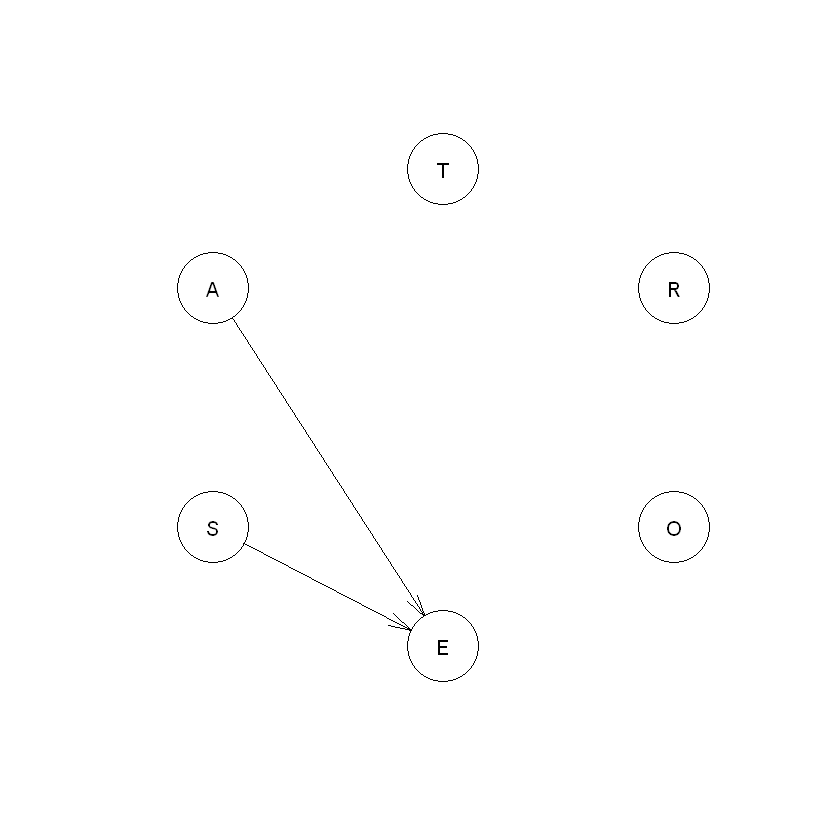

In [9]:
plot(dag)


El nivel de educación tiene una fuerte influencia en la ocupación del individuo, así como en su lugar de residencia:

In [10]:
dag <- set.arc(dag, from = "E", to = "O") 
dag <- set.arc(dag, from = "E", to = "R")

Finalmente, los medios de transporte preferidos por el individuo están directamente influidos por su lugar de residencia y su ocupación. En cuanto al primer factor, la distancia al lugar de trabajo desde la residencia influye directamente en la opción de transporte. Por otra parte, algunos trabajos requieren viajes periódicos de larga distancia, mientras que otros requieren trayectos más frecuentes sobre cortas distancias.

In [11]:
dag <- set.arc(dag, from = "R", to = "T")
dag <- set.arc(dag, from = "O", to = "T")

Finalmente, queda definido el grafo como:

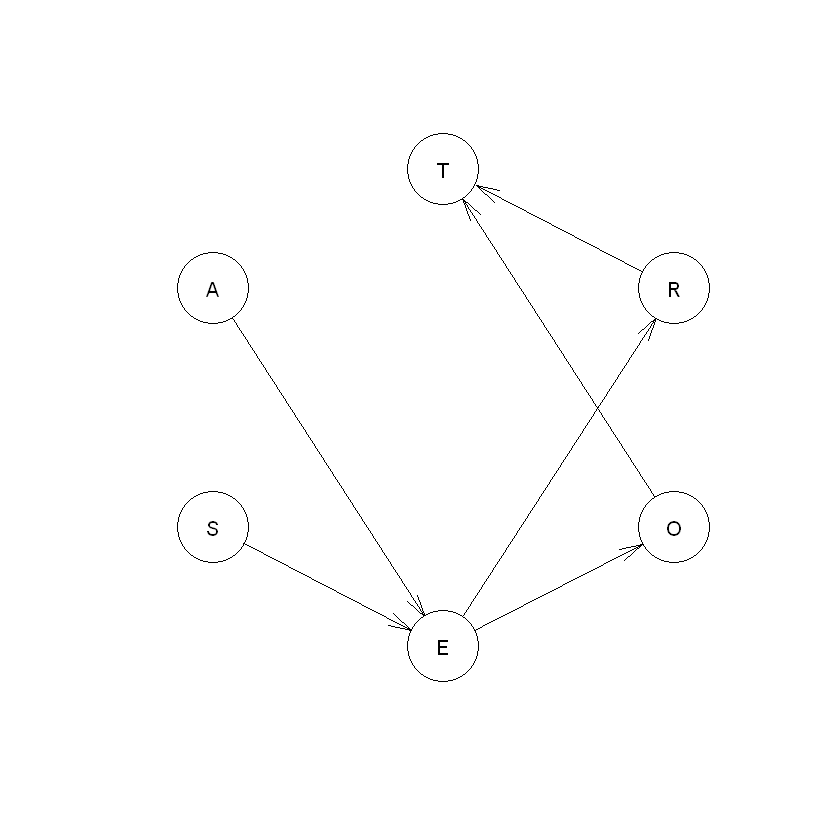

In [12]:
plot(dag)

In [13]:
modelstring(dag)

[1] "[A][S][E|A:S][O|E][R|E][T|O:R]"

De este modo, las dependencias de cada variable quedan definidas por la barra vertical (|) que usamos habitualmente para la fórmula de probabilidad condicionada y separadas por dos puntos :. Por ejemplo, `[E|A:S]` significa que se dan los arcos $A \rightarrow E$ y $S \rightarrow E$ (sexo y edad son padres de empleo). Esta notación se asemeja por tanto a un producto de probabilidades condicionadas, del tipo $P(E | A,S)$, lo que concuerda con el hecho de que cada una de ellas es un factor de la descomposición en la distribución global hecha por nuestro grafo dag:

$P_{dag}(A,S,E,O,R,T)=P(A)P(S)P(E | A,S)P(O | E)P(R | E)P(T | O,R).$

Otras funciones útiles para explorar objetos de la clase `bn` son por ejemplo `nodes` y `arcs`:

In [14]:
nodes(dag)

[1] "A" "S" "E" "O" "R" "T"

In [15]:
arcs(dag)

from,to
A,E
S,E
E,O
E,R
R,T
O,T


Así como `parents()` y `children()`, para conocer los padres e hijos de los nodos del grafo:

In [16]:
parents(dag, node = "O")
parents(dag, node = "T")

[1] "E"

[1] "O" "R"

In [17]:
children(dag, node = "T")
children(dag, node = "E")

character(0)

[1] "O" "R"

### 2.2 Otra manera de definir el DAG

La forma anterior define arcos uno a uno, pero también podemos definir la estructura toda a la vez. La función `arcs()` es especialmente interesante ya que nos permite añadir arcos de manera más rápida. En este caso, se podrían definir las relaciones mediante una matriz de dos columnas similar a la devuelta por `arcs()`:

In [18]:
dag2 <- empty.graph(nodes = c("A", "S", "E", "O", "R", "T"))
arc.set <- matrix(c("A", "E",
                    "S", "E",
                    "E", "R",
                    "E", "O",
                    "O", "T",
                    "R", "T"),
                  byrow = TRUE, ncol = 2,
                  dimnames = list(NULL, c("from", "to")))
arcs(dag2) <- arc.set

El grafo resultante es idéntico al que se generó anteriormente:

In [19]:
all.equal(dag, dag2)

[1] TRUE

Ambas formas de definir el grafo garantizan que éste sea acíclico, ya que si se intenta introducir un ciclo en el mismo se producirá un error. Por ejemplo, si intentamos crear una relación directa entre `T` y `E`, lo que daría lugar a un ciclo, se produce un error:

In [20]:
set.arc(dag, from = "T", to = "E")

ERROR: Error in arc.operations(x = x, from = from, to = to, op = "set", check.cycles = check.cycles, : the resulting graph contains cycles.


#### Ejercicio 1.1

Construye un grafo razonable que modelice el conjunto de datos almacenados en coronary, que contiene las causas probables de factores de riesgo en trombosis coronaria, con las variables:

- Smoking: Fumador. Factores: no/yes .

- M. Work: Trabajo mental estresante. Factores: no/yes.

- P. Work: Trabajo físico estresante. Factores: no/yes.

- Pressure: Tensión sistólica. Factores: <140/>140.

- Proteins: Ratio de lipoproteinas (colesterol) HDL y LDL. Factores: <3/>3.

- Family: Familiar con enfermedad coronaria: Factores: neg/pos.

- Trombosis: Ocurrencia de trombosis. Factores no/yes.

Por el momento no te preocupes de las categorías de las variables.

In [47]:
dagCoronary <- empty.graph(nodes = c("Smoking", "Mwork", "Pwork", "Pressure", "Proteins", "Family","Trombosis"))
arc.set <- matrix(c("Smoking", "Trombosis",
                    "Family", "Trombosis",
                    "Mwork", "Pressure",
                    "Pwork", "Pressure",
                    "Trombosis", "Pressure"),
                  byrow = TRUE, ncol = 2,
                  dimnames = list(NULL, c("from", "to")))
arcs(dagCoronary) <- arc.set

#### Ejercicio 1.2

Hemos utilizado la función `arcs()`, pero se puede acceder a la estructura de arcos mediante `dag$arcs`. Añade un arco al grafo del **Ejercicio 1.1** modificando manualmente esta estructura y observa lo que ocurre para las funciones `parents()`, etc…

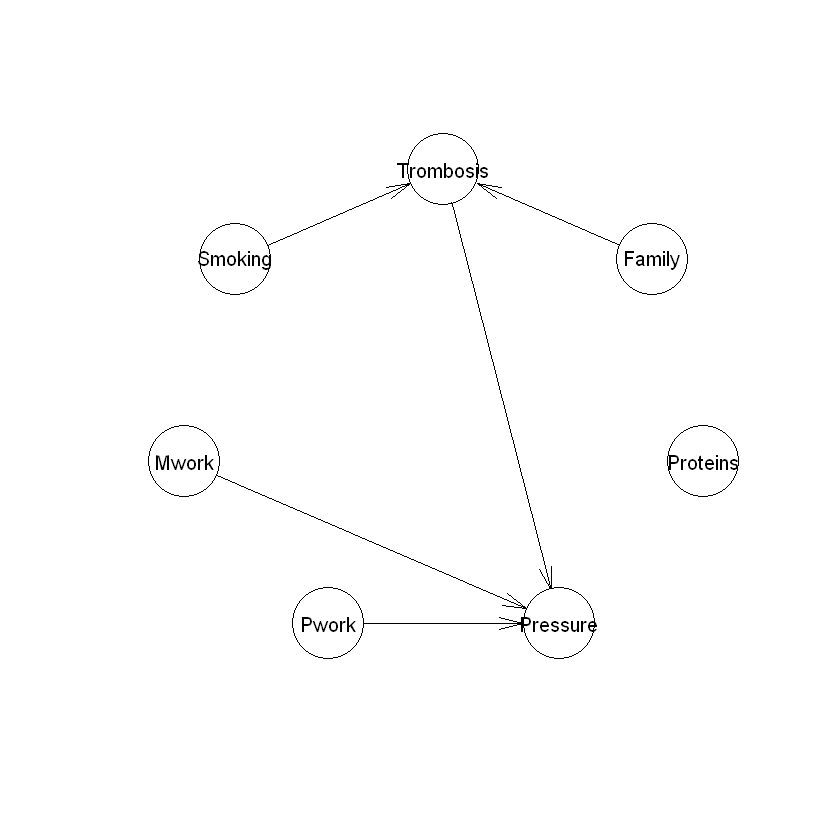

In [48]:
plot(dagCoronary)

## 2.3 Construcción de las tablas de probabilidad condicionada
### 2.3.1 Definición de los estados de las variables

Una vez representadas las interacciones entre variables mediante el grafo, es necesario especificar una distribución de probabilidad conjunta sobre todas las variables para obtener el modelo bayesiano de los datos de la encuesta. Todas ellas, como se dijo al principio, son variables discretas y definidas para una serie de estados ordenados (categorías, o `levels` en R), que se definen a continuación:

In [49]:
estados.A <- c("young", "adult", "old")
estados.S <- c("M", "F")
estados.E <- c("high", "uni")
estados.O <- c("emp","self")
estados.R <- c("small","big")
estados.T <- c("car","train","other")

En este caso, la distribución de probabilidad conjunta o global (JPD, Joint Probability Distribution), que denotamos con $P(\mathcal{X})$, tiene $3∗2∗2∗2∗2∗3$ estados, y por tanto $3∗2∗2∗2∗2∗3−1=143$ parámetros, que son las combinaciones resultantes, y esto tan solo con un modelo de $6$ variables, varias de las cuales son binarias.

En su lugar, y aprovechándonos de nuestro conocimiento sobre el conjunto de datos (conocimiento experto, a priori) hemos utilizado un modelo mucho menos complejo a nivel de parámetros, descartando muchas relaciones entre variables que sabemos a priori que no tienen sentido (e.g. la relación entre la edad `A` y el sexo `S` del encuestado).

Las variables que no se encuentran unidas por ningún arco se dice que son condicionalmente independientes. Por lo tanto, la factorización representada por la ecuación anterior es un submodelo de la distribución global que contiene muchos menos parámetros.

Llevado a nuestro ejemplo, el número de parámetros necesarios para definir la JPD en nuestro ejemplo es, gracias al DAG y denotando $\mathcal{B}$ la red bayesiana definida por dag,

$P_{\mathcal{B}}(A,S,E,O,R,T) = \underset{2}{P(A)}\underset{1}{P(S)}\underset{1·(3·2)}{P(E|A,S)}\underset{1·2}{P(O|E)}\underset{1·2}{P(R|E)}\underset{2·(2·2)}{P(T|O,R)}$,

$2+1+6+2+2+8=21$ parámetros (Obsérvese como el número de parámetros crece exponencialmente con el número de padres), con la idea de que $P_{\mathcal{B}}$ se ajuste suficientemente bien a la JPD, i.e. $P_{\mathcal{B}}\approx P$, y lo que sigue por tanto es definir esos parámetros.

### 2.3.2 Definición de las Tablas de Probabilidad Condicionada

Las Tablas de Probabilidad Condicionada (CPT) de cada variable viene dada por una función de probabilidad para cada combinación de estados de los padres, i.e. para un nodo X necesitamos definir las tablas de probabilidad $P(X \ | \ \Pi(X))$, quedando definida la función de probabilidad conjunta como $P_{dag}(\mathcal{X}) = \prod_{i=1}^pP(X_i \ | \ \Pi(X_i))$, donde $\Pi(X)$ son los padres de $X$.

Dado que las probabilidades condicionales pueden ser unidimensionales o venir en forma de tablas de varias dimensiones dependiendo del número de padres de cada nodo, utilizaremos para crear dichas probabilidades la función `array()`, que permite utilizar una interfaz común en todos los casos (`matrix()` es simplemente un elemento de tipo `array()` de dos dimensiones).

En la encuesta, la edad y el sexo vienen dadas por probabilidades unidimensionales, ya que son variables que no tienen padres en el grafo. Sólo tenemos por tanto que especificar sus marginales:

In [50]:
A.prob <- array(c(.3, .5, .2), dim = 3, dimnames = list(A = estados.A))
A.prob

A
young adult   old 
  0.3   0.5   0.2

In [51]:
S.prob <- array(c(.6, .4), dim = 2, dimnames = list(S = estados.S))
S.prob

S
  M   F 
0.6 0.4

*ocupación* y *residencia*, al depender de *educación*, se representan mediante una tabla de probabilidades condicionadas de dos dimensiones, i.e. necesitamos definir una probabilidad para cada estado del padre. Cada columna por tanto en este caso representa cada uno de los niveles del padre, manteniendo la distribución de la variable condicionada cada nivel particular, por lo que las probabilidades de cada columna siempre suman 1 (i.e. son una probabilidad):

In [52]:
O.prob <- array(c(.96,.04,.92,.08), dim = c(2,2), 
                  dimnames = list(O = estados.O, E = estados.E))
O.prob

,high,uni
emp,0.96,0.92
self,0.04,0.08


In [53]:
R.prob <- array(c(.25,.75,.2,.8), dim = c(2,2), 
                  dimnames = list(R = estados.R, E = estados.E))
R.prob

,high,uni
small,0.25,0.2
big,0.75,0.8


Por último, educación y transporte se modelizan en forma de tablas 3-dimensionales, dado que tienen 2 padres cada una y se debe especificar por tanto una probabilidad para cada estado de, en este caso, los 2 padres.

La primera dimensión debe ser la del nodo en sí, y a continuación se listan los padres. De manera que cada selección de las demás dimensiones $(2,...)$ corresponde a un estado de los padres, y por tanto produce una probabilidad.

In [54]:
# Tabla de probabilidades condicionales para el nodo Educacion
E.prob <- array(c(.75, .25, .72, .28, .88, .12, .64, .36, .70, .30, .90, .10),
                dim = c(2, 3, 2),
                dimnames = list(E = estados.E,
                                A = estados.A,
                                S = estados.S))
print(E.prob) # jupyter tiene su propio print

, , S = M

      A
E      young adult  old
  high  0.75  0.72 0.88
  uni   0.25  0.28 0.12

, , S = F

      A
E      young adult old
  high  0.64   0.7 0.9
  uni   0.36   0.3 0.1



In [55]:
# Tabla de probabilidades condicionales para el nodo Transporte
T.prob <- array(c(.48, .42, .1, .56, .36, .08, .58, .24, .18, .7, .21, .09),
                dim = c(3,2,2),
                dimnames = list(T = estados.T, 
                                O = estados.O,
                                R = estados.R))
print(T.prob)

, , R = small

       O
T        emp self
  car   0.48 0.56
  train 0.42 0.36
  other 0.10 0.08

, , R = big

       O
T        emp self
  car   0.58 0.70
  train 0.24 0.21
  other 0.18 0.09



Recuérdese que en `R` podemos seleccionar utilizando directamente el nombre, e.g. si queremos conocer la distribución de empleo para las “mujeres” de edad “adulta”,

In [56]:
E.prob[,"adult","F"]

high  uni 
 0.7  0.3

O tal vez queramos determinar cómo cambia la distribución entre gente con tamaño de población de residencia “pequeña” y “grande”:

In [57]:
T.prob[,,"small"] - T.prob[,,"big"]

,emp,self
car,-0.10,-0.14
train,0.18,0.15
other,-0.08,-0.01


Una vez definidos el grafo y la distribución de las probabilidades locales de cada variable, se combinan para crear la red bayesiana propiamente dicha. Como estamos creando las tablas manualmente (más tarde veremos cómo hacerlo de manera automática), utilizaremos la función `custom.fit()`, que requiere el DAG (clase `bn`) y una lista en la que se almacenan las diferentes tablas de probabilidades condicionadas, en la que cada elemento lleva el nombre de la variable correspondiente (la llamamos `cpt`, de *Conditional Probability Table*):

In [59]:
cpt <- list(A = A.prob, S = S.prob, E = E.prob, O = O.prob, R = R.prob, T = T.prob)
bn <- custom.fit(x = dag, dist = cpt)
class(bn)

[1] "bn.fit"      "bn.fit.dnet"

El objeto `bn` es la red bayesiana propiamente dicha, contiene el grafo y las tablas de probabilidad asociadas a cada nodo. Para `bnlearn` es un objeto de las clases `bn.fit` y `bn.fit.dnet`, es decir, es una “red bayesiana ajustada a unos datos”.

## 3 Consultas al grafo

La utilidad de la red probabilística radica en último término hallar de forma eficiente la probabilidad de cualquier nodo (o conjunto de nodos), dada una cierta información (*evidencia*). Este proceso se denomina *inferencia* o razonamiento probabilístico. Sin embargo, el grafo en sí también proporciona información cualitativa de nuestro conjunto de variables.

De la primera parte nos encargaremos en la siguiente práctica, por ahora nos centraremos en la parte cualitativa, con el objetivo de responder a preguntas del tipo *¿Son dos variables independientes dado un conjunto de variables?* Básicamente, le plantearemos cuestiones de independencia a nuestra red bayesiana, como si de un sistema experto se tratara.

### 3.1 Extraer propiedades básicas del grafo
#### 3.1.1 Número de parámetros de la factorización
Como se dijo anteriormente, el número de parámetros ($21$) de la red es mucho menor que el de la distribución de probabilidades global, que era de $143$. Puede consultarse cuántos parámetros tiene la red con `nparams()`:

Como se dijo anteriormente, el número de parámetros ($21$) de la red es mucho menor que el de la distribución de probabilidades global, que era de $143$. Puede consultarse cuántos parámetros tiene la red con `nparams()`:

In [60]:
nparams(bn)

[1] 21

#### 3.1.2 Arcos, nodos y estructuras gráficas
Del objeto resultante que contiene la definición de la red bayesiana pueden extraerse diversos parámetros referentes a la estructura del grafo, además de los arcos, arcs(), que ya hemos visto anteriormente.

In [61]:
# Arcos
arcs(bn)

from,to
A,E
S,E
E,O
E,R
O,T
R,T


In [62]:
# Nodos
nodes(bn)

[1] "A" "S" "E" "O" "R" "T"

In [63]:
# Padres de un determinado nodo
bnlearn::parents(bn, "E")

[1] "A" "S"

In [64]:
bnlearn::parents(bn, "A")

character(0)

In [65]:
bnlearn::children(bn, "A")


[1] "E"

Como se ha visto anteriormente, existen en esencia tres tipos de configuraciones en un DAG:

- $X \rightarrow Y \rightarrow Z$ (Estructura en serie o cascada) $ \Rightarrow X \perp_P Z \ | \ Y$.

- $X \leftarrow Y \rightarrow Z$ (Padre en común o divergentes) $ \Rightarrow X \perp_P Z \ | \ Y$.

- $X \rightarrow Y \leftarrow Z$ (Estructura en V) , $\Rightarrow X \perp_P Z, \ X \not \perp_P Z | Y$.


Las dos primeras estructuras codifican la misma d-separación, ya que los nodos X y Z con condicionalmente independientes dado Y (se suele decir que Y “bloquea” la unión entre X y Z). El tercer caso es el de la v-estructura, que indica que X y Z son independientes, sin embargo, si no se da Y, los nodos X y Z son independientes.

**Ejercicio 3.1**: Busca los tres tipos de estructuras para la red creada. Nota: En `bnlearn` existe la función `vstructs()`.

In [67]:
vstructs(bn)

X,Z,Y
A,E,S
O,T,R


### 3.1.3 Vecindad y Markov Blanket

La vecindad (neighborhood, `nbr`) y la Markov blanket (`mb`) de un nodo proporcionan una descripción sintética de la estructura de dependencia local alrededor de un nodo. La vecindad es los nodos a los que está conectado.

Intuitivamente, la Markov Blanket $\mathcal{M}(X) \subset \mathcal{X}$ de un nodo $X$ es el conjunto minimal de nodos que “separa” $X$ del resto, i.e. $X \perp_P (\mathcal{X} - \mathcal{M} - X) \ | \ \mathcal{M}$, y como sabemos, es el conjunto formado por sus padres, sus hijos y esposas (padres de sus hijos).

Se obtiene esta información con los comandos nbr (neighbourhood),

In [68]:
nbr(dag, "O")

[1] "E" "T"

y `mb` (markov blanket):

In [69]:
mb(dag, "O")

[1] "E" "R" "T"

También podemos utilizar los comandos anteriores para mostrar que ambos sets describen una relación simétrica, por ejemplo, si R está en la manta de Markov de `O`, `O` estará en la de `R`:

In [70]:
"R" %in% mb(dag, "O")
"O" %in% mb(dag, "R")

[1] TRUE

[1] TRUE

Además, podemos verificar fácilmente como la Markov blanket de un nodo cualquiera (O en este ejemplo), está compuesta por sus hijos (objeto chld), sus padres (objeto par), y las esposas (objeto o.par), por su propia definición:

In [71]:
chld <- bnlearn::children(dag, "O")
par <- bnlearn::parents(dag, "O")
o.par <- sapply(chld, bnlearn::parents, x = dag)
unique(c(par, chld, o.par[o.par != "O"]))

[1] "E" "T" "R"

In [72]:
mb(dag, "O")

[1] "E" "R" "T"

Recuérdese que, en general, toda esta información está contenida en el propio objeto, es decir, podemos ver, por ejemplo, la *Markov Blanket* de un nodo, haciendo

In [73]:
dag$nodes$A$mb

[1] "S" "E"

#### Ejercicio 3.2

Haz que A pertenezca a la Markov Blanket de `O` sin hacer `A` padre de `O`.

Por inspección visual. ¿Se ha eliminado alguna independencia?

¿Cuál es la nueva JPD $P_{dag}$?

Configura el grafo como estaba antes de este ejercicio.

### 3.1.4 Matriz de adyacencia

También podemos obtener la *matriz de adyacencia* de forma directa con `amat()`, que es otro modo de especificar las uniones entre nodos:

In [40]:
amat(dag)

,A,S,E,O,R,T
A,0,0,1,0,0,0
S,0,0,1,0,0,0
E,0,0,0,1,1,0
O,0,0,0,0,0,1
R,0,0,0,0,0,1
T,0,0,0,0,0,0


De hecho, dado un conjunto de nodos y la matriz de adyancencia (que podría contruirse a mano o ser importada desde otro formato), es posible definir un DAG completamente:

In [41]:
mat <- amat(dag)
dag3 <- empty.graph(nodes(dag))
amat(dag3) <- mat
all.equal(dag, dag3)

[1] TRUE

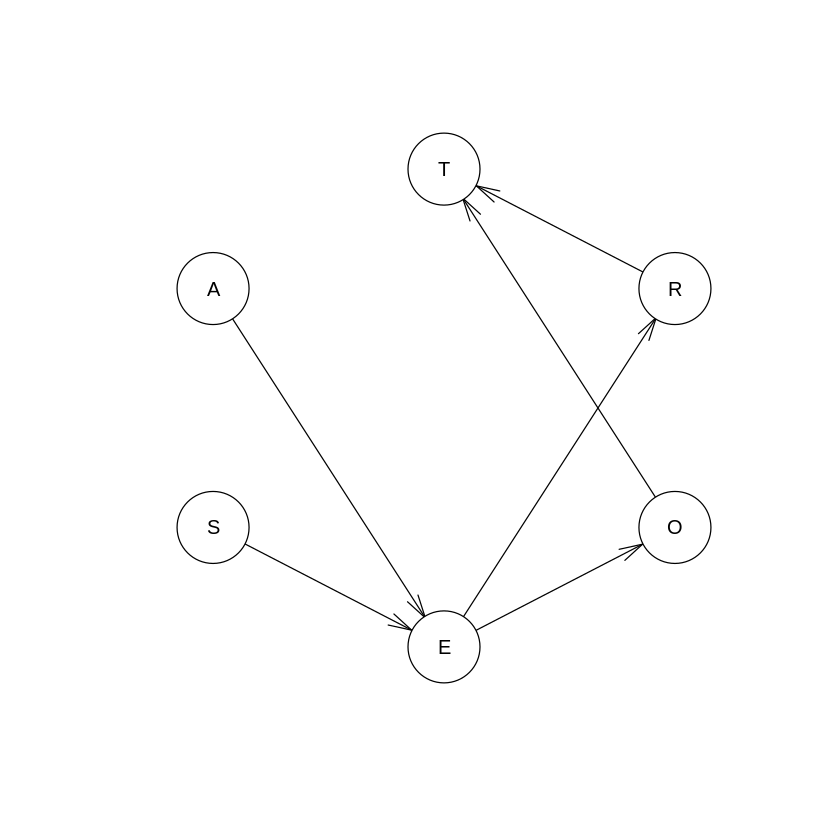

In [42]:
plot(dag3)

## 3.2 Consultas de independencia al DAG: d-separación

Podemos estudiar la asociación entre variables con la información contenida en nuestro grafo, almacenado en el objeto `dag`, mediante consultas de d-separación. Esto es posible mediante un análisis entre las conexiones del DAG, para comprobar si existe alguna conexión entre ellas, bien sea directa o indirecta, dependiendo de si la relación entre las dos variables está mediada por uno o más arcos respectivamente.

Si no existe dicha conexión entre las variables en el grafo, hablamos de separación dirigida, o d-separación. Los detalles de la d-separación ya se han visto anteriormente. En esta práctica, basta con recordar que la d-separación de dos variables ($\perp_G$) en la red bayesiana implica independencia probabilística ($\perp_P$). Recuérdese por tanto que si todas las trayectorias entre $X$ e $Y$ se encuentran bloqueadas por $Z$, se dice que $X$ e $Y$ son (condicionalmente) independientes dada variable $Z$, lo que representamos como $X \perp_G Y | Z$. Lo contrario no es necesariamente cierto: no todas las relaciones de independencia condicional se encuentran reflejadas en el grafo.

Podemos investigar la d-separación entre variables de un grafo con la función `dsep()`:

In [74]:
dsep(dag, x = "S", y = "R")

[1] FALSE

In [75]:
dsep(dag, x = "O", y = "R")

[1] FALSE

En los anteriores ejemplos las variables introducidas no son independientes. Esto podemos verlo en el grafo, donde el sexo (`S`) y el lugar de residencia (`R`) están conectados a través de educación (`E`). Del mismo modo, la ocupación (`O`) y el lugar de residencia están relacionadas a través de la educación (`E`).

De hecho, podemos comprobar que hay una conexión entre `S` y `R` el el DAG:

In [76]:
dsep(dag, x = "S", y = "R")

[1] FALSE

i.e. no están d-separados, pero si condicionamos a la educación, la conexión queda bloqueada y `S` y `R` son ahora independientes:

In [77]:
dsep(dag, x = "S", y = "R", z = "E")

[1] TRUE

Lo mismo aplica a la relación entre `O` y `R`. Ambas dependen de `E`, y por lo tanto ambas se vuelven independientes cuando condicionamos sobre `E`:

In [47]:
dsep(dag, "O", "R", "E")

[1] TRUE

Por el contrario, condicionar sobre un nodo particular puede también hacer que otros nodos marginalmente independientes pasen a ser dependientes. Por ejemplo,

In [48]:
dsep(dag, x = "A", y = "S")

[1] TRUE

In [49]:
dsep(dag, x = "A", y = "S", z = "E")

[1] FALSE

Efectivamente, se trata de una v-estructura. Si queremos hacer inferencia sobre el nodo `A` en este caso, necesitaremos además información sobre los nodos `S` y `E`. Este subconjunto de nodos constituye el Markov blanket de `A`, siendo el resto de los nodos del grafo redundantes para hacer inferencia sobre `A`:

In [50]:
mb(dag, "A")

[1] "S" "E"

Sabemos a partir del grafo que el estado de `E` esta influenciado por los estados de `A` y `S`, que son sus padres.

In [51]:
parents(dag, "E")

[1] "A" "S"

`A` su vez, `A` y `S` pasan a ser dependientes dado `E`. De forma equivalente, `E` depende de la distribución conjunta de `A` y `S`, $P(E | A,S)$; por tanto, de acuerdo con el Teorema de Bayes, tenemos:

$$\begin{aligned}
P(E \ | \ A,S) = \frac{P(A,S,E)}{P(A,S)} = \frac{P(A,S \ | \ E)P(E)}{P(A)P(S)} \alpha P(A,S \ | \ E),
\end{aligned}$$

y por lo tanto, cuando `E` es conocida, no podemos descomponer la probabilidad conjunta de `A` y `S` en una parte que dependa sólo de `A` y otra de `S`. No obstante, $P(A,S)=P(A | S)P(S)=P(A)P(S)$: tal y como se ha visto en el ejemplo anterior, `A` y `S` están d-separadas cuando no se condiciona a `E`.

#### Ejercicio 3.3

Carga el grafo del archivo grafo_ejercicio3.rda, que contiene la variable dag.3. Dibújalo y responde a las siguientes preguntas sobre él:

1. ¿Son Z y U independientes?

T = Z -> Y -> T -> R -> U
C = vacío
No existe v-est (X)
Los nodos YTR no están en C (V)
No hay camino activo, son independientes.

2. ¿Son Z y U dependientes? ¿¿¿???

3. ¿Son T y U independientes?

T = T -> R -> U
C = vacío
No existe v-est (X)
El nodo R no está en C (V)
No hay camino activo, son independientes

4. ¿Son T y U independientes dado R?

T = T -> R -> U
C = R
No existe v-est (X)
El nodo R está en C (X)
NO hay camino activo, son independientes

5. ¿Son Z y U independientes dado T?

6. ¿Son Z y U independientes dados T y R? No

7. ¿Son Z y U independientes dado X? No

8. ¿Son Z y U independientes dado X y S? No

9. ¿Son Z y U independientes dado X, S y K? No

10. ¿Son Z y U independientes dado X, S, K y T? No

11. ¿Son K y R independientes? Sí
o
12. X e Y, ¿Son independientes? Sí
r
13. ¿Son X e Y independientes si conocemos T? No
e
14. ¿Son K y T independientes? Sí
o
15. ¿Son K y Z independientes? Sí
s
16. ¿Son K y T independientes si conocemos R? Sí

17. ¿Son K y T independientes si conocemos U? Sí

18. ¿Son S y T dependientes? Sí

19. ¿Son X y Z independientes? Sí

20. ¿Son X y Z independientes si conocemos S? Sí

21. ¿Son X y Z independientes si conocemos S y U? Sí

22. Si conozco la variable Y, i.e. $Y=y_0$, ¿De qué variables es independiente $Z | Y=y_0$?

23. ¿Cuál es el conjunto minimal de variables necesario para que ninguna otra variable influya en T?

Loading required namespace: Rgraphviz



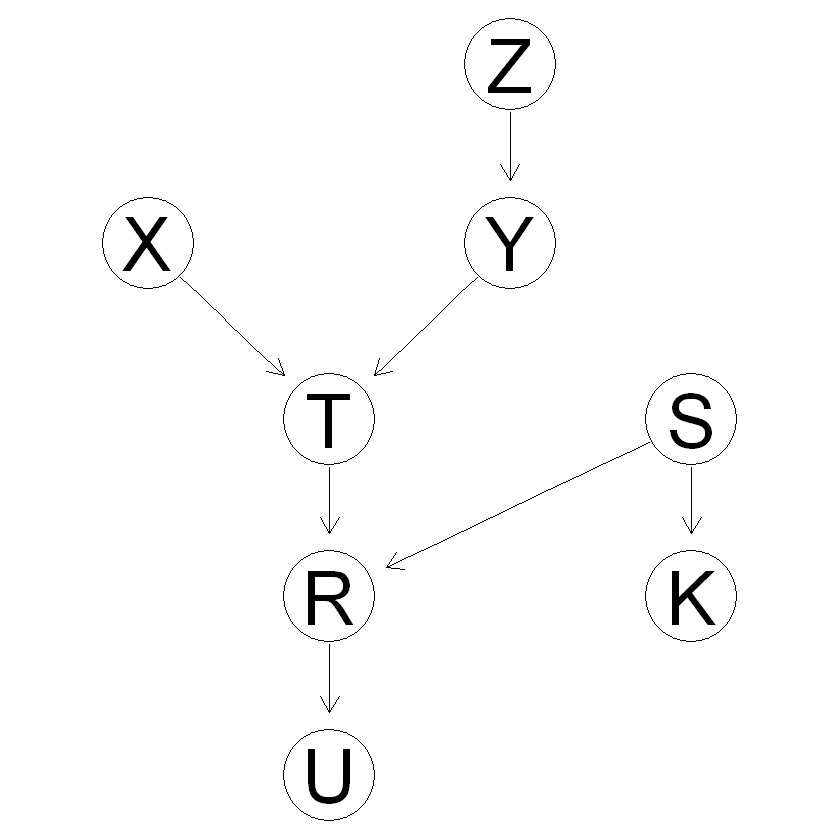

In [78]:
load("grafo_ejercicio3.rda")
graphviz.plot(dag.3)

## 4 Referencias
- Gutiérrez, J.M., Cano, R., Cofiño, A.S., Sordo, C., 2004. Redes probabilísticas y neuronales en las ciencias atmosféricas. Centro de Publicaciones, Ministerio de Medio Ambiente, Madrid, Spain.

- Scutari, M., Denis, J.-B., 2014. Bayesian networks: with examples in R.

- Scutari, M., 2014. Bayesian Network Constraint-Based Structure Learning Algorithms: Parallel and Optimised Implementations in the bnlearn R Package. http://arxiv.org/abs/1406.7648

- r-bayesian-networks. http://www.r-bayesian-networks.org/ (Last accessed 18 Nov 2017)

- Nagarajan, R., Scutari, M. and Lèbre, S. 2013. Bayesian networks in R: with applications in systems biology, Use R! Springer, New York.